In [1]:
import sys
sys.path.append('/Users/zhengj10/Python/Modules')
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import PatcherBot as pb
from glob import glob
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
# imgPath = '/Volumes/Backup Plus/PatcherBot/raw/'
imgPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw'
sumPath = '/Volumes/genie/Jihong_GENIE_stuff/Voltron 2 with_pos_to_neg_V_steps/'
os.path.exists(imgPath)

True

### Creation of dataframe

- Meta from experiment

In [3]:
datePath = ['2022.03.24_000']

In [4]:
columns = ['Date','Plate','Well','Mutation','Cell']

In [5]:
data_all = {}
for column in columns:
    data_all[column] = []

for date in datePath:
#     platePath = pb.getPathInfo(os.path.join(imgPath,date))
    platePath = ['plate_000']
    i=0
    for plate in platePath:
        print(plate)
        
        idxFile = os.path.join(imgPath, date, plate, '.index')
        a = yaml.load(open(idxFile), Loader=yaml.FullLoader)
        i+=1
        try:
            mutation = a['.']['mutation_1']
        except:
            mutation = 'not recorded'
        
        cellPath = pb.getPathInfo(os.path.join(imgPath, date, plate))
        print(mutation)
        for cell in(cellPath):
            trialPath = os.path.join(imgPath,date,plate,cell,'camera_clamp1_000')
            if not os.path.exists(trialPath):
                continue
                
            data_all['Date'].append(date)
            data_all['Plate'].append(plate)
            data_all['Well'].append('well_1')
            data_all['Mutation'].append(mutation)
            data_all['Cell'].append(cell)

plate_000
376.20950


In [6]:
for k,v in data_all.items():
    print(k,len(v))

Date 7
Plate 7
Well 7
Mutation 7
Cell 7


In [7]:
df_new = pd.DataFrame(data_all)
df_new

,Date,Plate,Well,Mutation,Cell
0,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0005_000
1,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0006_000
2,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0009_000
3,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0012_000
4,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0013_000
5,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0014_000
6,2022.03.24_000,plate_000,well_1,376.20950,patch_attempt_0015_000


- Calculate dFF and add to dataframe

In [8]:
def get_dff(trace,fb):
    f0 = np.mean(trace[300:400])
    df = np.mean(trace[950:1050])-f0
    dff = df/(f0-fb)
    return dff

In [9]:
def get_peak_dff(trace,fb,neg=True):
    dff = get_dff(trace,fb)
    if neg:
        if i<6:
            peak_dff = np.min(dff)
        else:
            peak_dff = np.max(dff)
    else:
        if i<6:
            peak_dff = np.max(dff)
        else:
            peak_dff = np.min(dff)
    return dff

In [10]:
# def get_peak_dff(trace,fb,i,neg=True):
#     if neg:
#         if i < 6:
#             f0 = np.min(trace[300:400])
#             df = np.min(trace)-f0
#         else:
#             f0 = np.max(trace[300:400])
#             df = np.max(trace)-f0           
#     else:
#         if i < 6:
#             f0 = np.max(trace[300:400])
#             df = np.max(trace)-f0
#         else:
#             f0 = np.min(trace[300:400])
#             df = np.min(trace)-f0   
        
#     dff = df/(f0-fb)
#     return dff

In [11]:
def get_leak(maFile): # maFile is Clamp2.ma file (for manipulator_2)
    data = h5py.File(maFile,'r')
    IV_traces = data['data'][()]
    leak = np.mean(IV_traces[0][9000:11000])
    leak = leak * 1e12 # convert to pA
    return leak

In [12]:
def get_Ra(maFile,i): # maFile is Clamp2.ma file (for manipulator_2)
    data = h5py.File(maFile,'r')    
    IV_traces = data['data'][()]
    leak = get_leak(maFile)
    if i < 6:
        I_peak = np.max(IV_traces[0][19000:21000])
        I_peak = I_peak * 1e12 # convert to pA
        I_peak = I_peak - leak
    else:
        I_peak = np.min(IV_traces[0][19000:21000])
        I_peak = I_peak * 1e12
        I_peak = I_peak - leak
    V = np.mean(IV_traces[2][39000:41000]) - np.mean(IV_traces[2][9000:11000])
    Ra = V*1e6/I_peak # Convert to megaOhm
    return Ra

### Create mask and get dFF etc

2022.03.24_000 plate_000 patch_attempt_0005_000
2022.03.24_000 plate_000 patch_attempt_0006_000
2022.03.24_000 plate_000 patch_attempt_0009_000
2022.03.24_000 plate_000 patch_attempt_0012_000
2022.03.24_000 plate_000 patch_attempt_0013_000
2022.03.24_000 plate_000 patch_attempt_0014_000
2022.03.24_000 plate_000 patch_attempt_0015_000


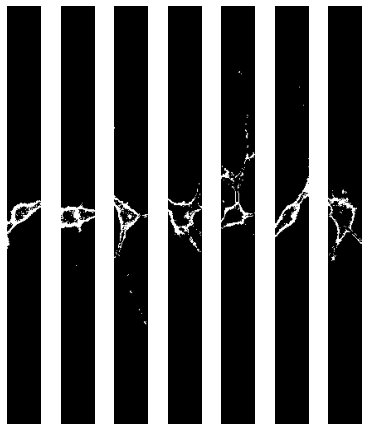

In [13]:
plt.figure(figsize=[15,18])

dFF_all = []
peak_dFF_all = []
Leak = []
Ra = []
Leak_min = []
Ra_max = []
light_source = []
power = []

for i,r in df_new.iterrows():
    print(r['Date'],r['Plate'],r['Cell'])
    
    imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000/000/Camera/frames.ma')  
    imgData = h5py.File(imgData,'r')
    imgData = imgData['data'][()]
    
    p_val = []
    for row in range(imgData.shape[1]):
        for c in range(imgData.shape[2]):
            a = imgData[100:400,row,c]
            b = imgData[750:1050,row,c]
            stat, p = mannwhitneyu(a, b, alternative='two-sided')
            p_val.append(p)
            
    p_val_2d = np.reshape(p_val,[imgData.shape[1],imgData.shape[2]])
    thre = sorted(p_val)[500] # Pick up 500 lowest p_val
    
    mask = p_val_2d<thre
    ax = plt.subplot(3,20,i+1)
    ax.imshow(mask,cmap='gray')
    ax.axis('off')
  
    dff_single_cell = []
    peak_dff_single_cell = [] # For Voltron peak-dFF
    leaks = []
    ra_s = []
    for trial in range(9):
        imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000',str(trial).zfill(3),'Camera/frames.ma')
        ivFile = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000',str(trial).zfill(3),'Clamp1.ma')
        
        imgData = h5py.File(imgData,'r')
        imgData = imgData['data'][()]
        leak = get_leak(ivFile)
        if trial !=6: # voltage amplitude = 0
            ra = get_Ra(ivFile,trial)
        
        leaks.append(leak)
        ra_s.append(ra)
        
#         f_single_trial = imgData*mask
#         f_single_trial = np.sum(f_single_trial,axis=1)
#         f_single_trial = np.sum(f_single_trial,axis=1)

        f_single_trial = []
        for frame in range(imgData.shape[0]):
            act_pix = imgData[frame,:,:]*mask
            f_single_frame = np.sum(act_pix)/np.sum(mask)
            f_single_trial.append(f_single_frame)

        imgMean = np.mean(imgData,axis=0)
        imgMean = imgMean.flatten()
        fb = sorted(imgMean)[int(imgMean.shape[0]*0.06)]
        
        dff_single_trial = get_dff(f_single_trial,fb)
        
#         if r['Date'] in ['476.2046','476.4496']:
#             neg=False
#         else:
#             neg=True
        neg = True
            
        peak_dff_single_trial = get_peak_dff(f_single_trial,fb,neg=True)
        dff_single_cell.append(dff_single_trial)
        peak_dff_single_cell.append(peak_dff_single_trial)
    
    Leak.append(leaks)
    Ra.append(ra_s)
    Leak_min.append(np.min(leaks))
    Ra_max.append(np.max(ra_s))
    
    dFF_all.append(dff_single_cell)
    peak_dFF_all.append(peak_dff_single_cell)
    
#     if mutation in ['487.1','487.6']:
#         light_source.append('Cyan')
#         power.append(10)
    
#     elif mutation in ['557.1','557.2','558.1','558.2']:
#         light_source.append('Yellow')
#         power.append(40)
#     else:
#         light_source.append('Teal')
#         power.append(40)

    light_source.append('Cyan')
    power.append(40)

plt.tight_layout()
plt.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/220329/mask_220324_plate_000.png')
plt.show()

In [ ]:
imgData.shape

In [ ]:
df_new['dFF'] = dFF_all
df_new['peak_dFF'] = peak_dFF_all
df_new['Leak'] = Leak
df_new['Ra'] = Ra
df_new['Leak_min'] = Leak_min
df_new['Ra_max'] = Ra_max
# df_new['Light_source'] = light_source
df_new['Light_source'] = 'Cyan'
df_new['Power (%)'] = power

In [ ]:
df_new

### Append to existing data

In [ ]:
df_new.shape

In [ ]:
sumPath = '/Users/zhengj10/Desktop/Ongoing_project/ASAP_PatcherBot_Pos_to_Neg'

In [ ]:
df = pd.read_pickle(sumPath+'Summary_pos_to_neg_VC_500_lowest_p_val.pkl')
print(df.shape)


In [ ]:
# df = df.drop(list(np.arange(390,415)))
# df

In [ ]:
df = df.append(df_new, ignore_index=True)
df.shape


In [ ]:
df

In [ ]:
df_new.to_pickle('/Users/zhengj10/Desktop/Ongoing_project/ASAP_PatcherBot_Pos_to_Neg/Summary_pos_to_neg_VC_500_lowest_p_val.pkl')

In [ ]:
df_new

### Plot

In [ ]:
# df = pd.read_pickle(sumPath+'summary.pkl')
df = pd.read_pickle('/Users/zhengj10/Desktop/Ongoing_project/ASAP_PatcherBot_Pos_to_Neg/Summary_pos_to_neg_VC_500_lowest_p_val.pkl')
df.shape

In [ ]:
# df = df.drop(278)
# df[df.Mutation=='421.1076']

In [ ]:
threshold = {'leak':-100, 'Ra':30}

In [ ]:
df_p = df[(df.Leak_min>threshold['leak'])&(df.Ra_max<threshold['Ra'])]
df_p.shape


- FV curve

In [ ]:
df

In [ ]:
df_p.Mutation.unique()

In [ ]:
labels_dict = {
    # Voltron and Voltron 2
    '421.1':'Voltron',
    '476.1':'Voltron-ST',
    '421.2096':'Voltron 2',
    '476.4495': 'Voltron 2-ST',
    
    # Voltron and Voltron 2 with TiCnC tag
    
    '607.1':'Voltron-TiCnC',
    '607.2':'Voltron 2 TiCnC',
    
    
    '476.2046':'Positron-ST',
    '476.4496':'Positron 2-ST',
    
    
    # Voltron Combo mutants
    '421.4909':'Voltron N69E R78H A122D V196P',
    '421.4919':'Voltron R78H A122D V196P',
    '421.4876':'Voltron N69E A122D',
    '421.4892':'Voltron N69E V196P',
    '421.6051':'Voltron R78H L89C A122D V196P',
    '421.5649':'Voltron Y63L N69E L89C A122D',
    '421.6052':'Voltron Y63L L89C A122D V196P',
    '421.5658':'Voltron Y63L L89C A122D',
    '421.4951':'Voltron Y63L V74W L89T',
    '421.5657':'Voltron R78H L89C A122D',
    '421.5659':'Voltron L89C A122D',
    '421.5650':'Voltron N69E L89C A122D',
    '421.5657':'Voltron R78H L89C A122D',
    '421.5616':'Voltron V74E L89C',
    '421.5619':'Voltron Y63L L89C',
    '421.5658':'Voltron Y63L L89C A122D',
    '421.5649':'Voltron Y63L N69E L89C A122D',
    '421.5462':'Voltron N69E R78H N81S L89C A122D',
    '421.5951':'Voltron R78H N81S L89C A122D',
    '421.6051':'Voltron R78H L89C A122D V196P',
    '421.5922':'Voltron Y63L A122D V196P',
    '421.6052':'Voltron Y63L L89C A122D V196P',
    '421.6004':'Voltron Y63L N69E N81S',
    '421.6155':'Voltron Y63L L89T A122D V196P',
    '421.5952':'Voltron Y63L N81S L89C A122D',
    '421.5444':'Voltron Y63L R78H A122D V196P',
    '421.5953':'Voltron V74W R78H N81S L89C A122D',
    '421.6232':'Voltron Y63L V74E N81S',
    '421.5076':'Voltron Y63L N69E R78H N81S L89C',
    '421.5740':'Voltron V74E R78H N81S V196P',
    '421.4911':'Voltron N69E A122D V196P',
    '421.5152':'Voltron N69E V74W R78H N81S L89C A122H V196P',
    '421.5387':'Voltron V74E R78H L89C V196P',
    '421.5414':'Voltron V74W R78H L89C A122H V196P',
    '421.5448':'Voltron R78H A122H V196P',
    '421.5617':'Voltron Y63L R78H L89C',
    '421.5751':'Voltron N69E R78H N81S A122D V196P',
    '421.4850':'Voltron N69E R78H',
    '421.4875':'Voltron Y63L N69E R78H A122D',
    '421.4882':'Voltron R78H A122D',
    '421.4910':'Voltron Y63L N69E A122D V196P',
    '421.5760':'Voltron R78H N81S A122D V196P',
    '421.6053':'Voltron L89C A122D V196P',
    '421.6038':'Voltron Y63L N69E R78H L89C A122D V196P',
    '421.4925':'Voltron N69E R78H A122H V196P',
    '421.6138':'Voltron N69E R78H A122D',
    '421.5619':'Voltron Y63L L89C',
    
    # Voltron Single mutants
    '421.2907':'Voltron A122X',
    '421.2335':'Voltron Y63P',
    '421.2336':'Voltron Y63T',
    '421.2346':'Voltron Y63I',
    '421.3002':'Voltron V74D',
    '421.3046':'Voltron V74S',
    '421.3028':'Voltron V74W',
    '421.303':'Voltron Y146X',
    '421.3012':'Voltron V74G',
    '421.2379':'Voltron Y63K',
    '421.2347':'Voltron Y63D',
    '421.3067':'Voltron V74H',
    '421.2203':'Voltron R78N',
    '421.3006':'Voltron V74P',
    '421.1069':'Voltron N69E',
    '421.1076':'Voltron N69P',
    '421.3054':'Voltron V74E',
    '421.3167':'Voltron L89T',

    # ASAP1 variants
    '376.1':'ASAP1',
    '376.13':'ASAP1 (T392V)',
    
    # ASAP3b variants
    '414.1':'GS-ASAP3b',
    '376.20950':'ASAP3b (T392V)',
    '376.20949':'ASAP3b (T392Y)',
    '485.20950':'ASAP3b (T392V)-ST',
    '376.20948':'ASAP3b',
    '485.20949':'ASAP3b (T392Y)-ST',
    '485.6':'ASAP3b-ST',
    '376.17995':'ASAP3b N391L T392I',
    '376.18153':'ASAP3b N391I T392V',
    '533.1':'ASAP3b-Kv',
    
    # Amy's Feb batch of ASAP3b variants
    'ASAP3b.T392V.H':'pCAG0–ASAP3b (T392V)-NL-SOM2 (Lin)',
    'ASAP3b.T392V.G':'pCAG0–ASAP3b (T392V)-lTlcnC',
    'ASAP3b.T392V.F':'pCAG0–ASAP3b (T392V)-NL-SOM2 (GENIE)',
    'ASAP3b.T392V.I':'pCAG0–ASAP3b (T392V)-GSS3-SOM2-lTlcnC',
    'ASAP3b.T392V.J':'376.2095 / pCAG-ASAP3b (T392V)',
    'ASAP3b.T392V.C':'pCAG0–ASAP3b (T392V)-GSSlong-SOM2 (GENIE)',
    'ASAP3b.T392V.B':'pCAG0–ASAP3b (T392V)-KGC-GSS3-ER2-GSS3-SOM2 (GENIE)',
    'ASAP3b.T392V.A':'pCAG0–ASAP3b (T392V)-GSS3TR-SOM2 (GENIE)',
    'ASAP3b.T392V.E':'485.2095 / pCAG–ASAP3b (T392V)-TS-ER-SOM2',
    'ASAP3b.T392V.D':'533.1 / pCAG-ASAP3-Kv (Lin)',    
    
    # Amy's Jul batch of ASAP3b variants
    'N4':'ASAP3b (T392V)-TS-ER-SOM2 miniprep',
    'O5':'ASAP3b (T392V)-GSSlong-SOM2 (GENIE)',
    'M3':'ASAP3b (T392V)-NL-SOM2 (GENIE)',
    'L2':'ASAP3b (T392V)-GSS3-SOM2-lTlcnC',
    'Q7':'ASAP3b (T392V)-GSS3TR-SOM2 (GENIE)',
    'P6':'ASAP3b (T392V) maxiprep',
    'S9':'ASAP3b (T392V)-NL-SOM2 (Lin)',
    'T10':'pCAG-ASAP3b (T392V)-lTlcnC',
    'R8':'ASAP3b-TS-ER-SOM2 maxiprep',
    'W13':'ASAP3b (T392V) miniprep',
    'X14':'ASAP3-Kv (Lin) maxiprep',
    'Y15':'ASAP3b-TS-ER-SOM2 miniprep',
    'U11':'ASAP3-Kv (Lin) miniprep',
    'V12':'ASAP3b (T392V)-KGC-GSS3-ER2-GSS3-SOM2 (GENIE)',
    'K1':'ASAP3b (T392V)-TS-ER-SOM2 maxiprep',
    
    # Other Ace2N based sensors
    '487.1':'Ace2N-4AA-mNeon',
    '557.1':'CMV-VARNAM',
    '558.1':'CAG-VARNAM',
    '487.6':'Ace2N-4AA-mNeon A122D',
    '488.6':'Ace2N-4AA-mNeon A122D-ST',
    '558.2':'CAG-VARNAM A122D',
    '557.2':'CMV-VARNAM A122D'
}


In [ ]:
# df

In [ ]:
fig = plt.figure(figsize=[5,5]) # for fig.2a

sns.set(style='whitegrid')
x = np.linspace(-110,50,9)
# sensors = ['476.2046','476.4496']
sensors = ['485.20950']
# sensors = ['607.1','607.2']
ax= plt.subplot(111)

colors_dict = {
    '607.1':'k',
    '607.2':'r',
    '476.2046':'#336699',
    '476.4496':'#FF3333',
    '485.20950':'r'
}



for sensor in sensors:
    df_sensor = df_p[df_p.Mutation==sensor]
    mean = np.mean(df_sensor['dFF'].to_list(),axis=0)
    sem = np.std(df_sensor['dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    mean = np.flip(mean)*100
    sem = np.flip(sem)*100
    
    if sensor=='607.1':    
        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+'_steady (%d)' %len(df_sensor),
               color=colors_dict[sensor])
    else:
        ax.errorbar(x, mean, yerr=sem, fmt = 'o-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
               color='k')

    if sensor=='607.1':
        mean = np.mean(df_sensor['peak_dFF'].to_list(),axis=0)
        sem = np.std(df_sensor['peak_dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
        mean = np.flip(mean)*100
        sem = np.flip(sem)*100
        ax.errorbar(x, mean, yerr=sem, fmt = '--',label = labels_dict[sensor]+'_peak (%d)' %len(df_sensor),
                   color='k')
    
    
ax.set_xlabel('mV')
ax.set_ylabel('\u0394F/F (%)')


leg = ax.legend(frameon=False)

for item in leg.legendHandles: # remove line marker in legend
    item.set_visible(False)
for artist, text in zip(leg.legendHandles, leg.get_texts()): # set text the same color as line
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    
# plt.setp(ax, xticks=x)
# plt.text(-5, -10, 'Voltron V74W', color='gray',size=10)
# plt.text(-2, -28, 'Voltron V74G', color='gray', size=10)
    
plt.xticks(x)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/210427/Ace-2N_mNeon.png')
# plt.savefig('/Users/zhengj10/Desktop/v_2.png',dpi=1200)
# plt.savefig('/Users/zhengj10/Desktop/GENIE/Manuscript/Voltron 2 paper/Voltron 2 paper_v9/2A_Voltron_Voltron2_dFF.pdf',format='pdf')
# plt.savefig('/Users/zhengj10/Desktop/210707/Voltron-TiCnC vs Voltron-TiCnC 2.png')
plt.savefig('/Users/zhengj10/Desktop/485.20950.png',format='png')
plt.show()

In [ ]:
df_sensor

In [ ]:
sem

In [ ]:
import matplotlib
from matplotlib import font_manager
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


fig = plt.figure(figsize=[5.7,4.5]) # for Voltron 2 paper single mutants
# fig = plt.figure(figsize=[8.4,5]) # for Voltron 2 paper combo mutants_1
# fig = plt.figure(figsize=[8.7,5]) # for Voltron 2 paper combo mutants_2
# fig = plt.figure(figsize=[4.2,4.5]) # for mNeon & VARNAM
# fig = plt.figure(figsize=[3.5,4.7]) # for fig.2a
# fig = plt.figure(figsize=[6,5]) # for default plotting with smaller N
# fig = plt.figure(figsize=[8.9,5]) # with legend
# fig = plt.figure(figsize=[4.75,5]) # without legend

sns.set(style='whitegrid')
x = np.linspace(-110,50,9)
# x = [-110,-90,-50,-30,-10,10,30,50]

# sensors = ['421.1','421.2096']

# sensors = ['421.1','421.2096','421.3028','421.3012']

# sensors = ['421.4909','421.2096']

# sensors = ['421.1','476.1']

sensors = ['421.1','421.2096','421.3012','421.3028','421.2336','421.2203','421.3067','421.1069','421.1076',
           '421.3054', '421.3167']

# sensors = ['476.1','607.1','607.2']

# sensors = ['421.1','421.2096','421.5414','421.5448','421.5617','421.5751','421.4850','421.4875','421.4882',
#            '421.4910','421.5760','421.6053','421.5462','421.5659','421.6004','421.6038','421.4925','421.6138',
#            '421.5619']

# sensors = ['421.1','421.2096','421.5649','421.4909','421.5657','421.5616','421.6051','421.5951','421.4919',
#            '421.4892','421.5658','421.6052','421.4876','421.5650','421.6155','421.5952','421.4911','421.5152',
#            '421.5387']

# sensors = ['557.1','557.2']

# sensors = ['558.1','558.2']

# sensors = ['487.1','487.6']

# sensors = ['421.1','421.2096','421.3012','421.3028','421.2336','421.2203','421.3067','421.1069','421.1076',
#            '421.3054', '421.3167','421.5414','421.5448','421.5617','421.5751','421.4850','421.4875','421.4882',
#            '421.4910','421.5760','421.6053','421.5462','421.5659','421.6004','421.6038','421.4925','421.6138',
#            '421.5619','421.5649','421.4909','421.5657','421.5616','421.6051','421.5951','421.4919',
#            '421.4892','421.5658','421.6052','421.4876','421.5650','421.6155','421.5952','421.4911','421.5152',
#            '421.5387']



lw = 2
ax= plt.subplot(111)

n = len(sensors)
colors = plt.cm.tab20(np.linspace(0,1,n))
c=0

alpha = 0.5

# mean_all_100mV = []
# sem_all_100mV = []
# A = []
# B = []

column_A = []
column_B = []


C_ANOVA = []

data_dict = {}

data_dict['Sensor'] = []
data_dict['Value'] = []

for sensor in sensors:
    df_sensor = df_p[df_p.Mutation==sensor]
    
#     c_ANOVA = []

#     for i,r in df_sensor.iterrows():
#         c_ANOVA.append(r['peak_dFF'][1])
#         data_dict['Sensor'].append(sensor)
#         data_dict['Value'].append(r['peak_dFF'][1])
                
#         if sensor == '557.1':
#             A.append(r['peak_dFF'][7]-r['peak_dFF'][5])
#         else:
#             B.append(r['peak_dFF'][7]-r['peak_dFF'][5])
    
#     C_ANOVA.append(c_ANOVA)
#     mean_sensor_norm = np.mean(mean_sensor)/40.0
#     sem_sensor_norm = np.std(mean_sensor)/(40*np.sqrt(len(df_sensor)))

#     print(sensor)
#     print(mean_sensor_norm)
#     print(sem_sensor_norm)
        
    mean = np.mean(df_sensor['peak_dFF'].to_list(),axis=0)
    sem = np.std(df_sensor['peak_dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    mean = np.flip(mean)*100
    sem = np.flip(sem)*100

    column_A.append(labels_dict[sensor])
    column_B.append(mean[-2])
#     print(mean.shape)
#     mean_all_100mV.append(mean[7])
#     sem_all_100mV.append(sem[7])

    if sensor in ['421.1','487.1','557.1']:
#         mean = np.mean(df_sensor['dFF'].to_list(),axis=0)
#         sem = np.std(df_sensor['dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
#         mean = np.flip(mean)*100
#         sem = np.flip(sem)*100
#         if sensor == '558.1':
#             ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
#                    color='#336699',alpha=alpha)
#         else:
#             ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
#                    color='#336699')
        

        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color='#336699')
        
    elif sensor in ['558.1']:
        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color='#336699',alpha=alpha)
        
        
    elif sensor in ['421.2096','487.6','557.2']:
#         mean = np.mean(df_sensor['dFF'].to_list(),axis=0)
#         sem = np.std(df_sensor['dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
#         mean = np.flip(mean)*100
#         sem = np.flip(sem)*100
#         if sensor == '558.2':
#             ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
#                    color='#FF3333',alpha=alpha)
#         else:
            
#             ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
#                    color='#FF3333')

        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color='#FF3333')
        
    elif sensor in ['558.2']:

        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color='#FF3333',alpha=alpha)
        
    elif sensor in ['476.4495']:

        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color='k',alpha=0.8)
#     elif sensor in ['421.3028','421.3012']:
#         mean = np.mean(df_sensor['peak_dFF'].to_list(),axis=0)
#         sem = np.std(df_sensor['peak_dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
#         mean = np.flip(mean)*100
#         sem = np.flip(sem)*100
#         ax.errorbar(x, mean, yerr=sem, fmt = '-',color='gray')
        
        
    else:
#         mean = np.mean(df_sensor['dFF'].to_list(),axis=0)
#         sem = np.std(df_sensor['dFF'].to_list(),axis=0)/np.sqrt(len(df_sensor))
#         mean = np.flip(mean)*100
#         sem = np.flip(sem)*100
# #         ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor))
        
#         ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
#             color=colors[c])

        ax.errorbar(x, mean, yerr=sem, fmt = '-',label = labels_dict[sensor]+' (%d)' %len(df_sensor),
                    color=colors[c])
        
        c+=1
    
ax.set_xlabel('mV')
ax.set_ylabel('\u0394F/F (%)')

## Following legend commands designed for Voltron 2 paper
font = font_manager.FontProperties(weight='bold',style='normal')

leg = ax.legend(handlelength=0,handletextpad = -0.19, markerscale = 0,bbox_to_anchor=(1,1),frameon=False,prop=font)

# leg = ax.legend(markerscale=0, loc='upper right')
for item in leg.legendHandles: # remove line marker in legend
    item.set_visible(False)
for artist, text in zip(leg.legendHandles, leg.get_texts()): # set text the same color as line
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    
# plt.setp(ax, xticks=x)
# plt.text(-5, -10, 'Voltron V74W', color='gray',size=10)
# plt.text(-2, -28, 'Voltron V74G', color='gray', size=10)
    
plt.xticks(x)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/210427/Ace-2N_mNeon.png')
# plt.savefig('/Users/zhengj10/Desktop/v_2.png',dpi=1200)
# plt.savefig('/Users/zhengj10/Desktop/GENIE/Manuscript/Voltron 2 paper/Voltron 2 paper_v9/2A_Voltron_Voltron2_dFF.pdf',format='pdf')
# plt.savefig('210427/Voltron 2.png')
plt.savefig('/Users/zhengj10/Desktop/2F_Voltron_single_mutants.pdf',format='pdf')
plt.show()


In [ ]:
df_q = pd.DataFrame({'Sensor':column_A,'dFF_at_30_mV':column_B})

In [ ]:
df_q

In [ ]:
df_q.to_excel('/Users/zhengj10/Desktop/dFF_at_30_mV_single_mutants.xlsx')

In [ ]:
data_dict

In [ ]:
df_stat = pd.DataFrame(data_dict)
df_stat

In [ ]:
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

In [ ]:
lm = sfa.ols('Value ~ C(Sensor)', data=df_stat).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
sp.posthoc_dunn(df_stat, val_col='Value', group_col='Sensor', p_adjust='holm')

In [ ]:
from scipy.stats import f_oneway

In [ ]:
f_oneway(C_ANOVA[0],C_ANOVA[1],C_ANOVA[2],C_ANOVA[3])

In [ ]:
C_ANOVA

In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

In [ ]:
mannwhitneyu(np.array(A)*100/40.0,np.array(B)*100/40.0,alternative='two-sided')

In [ ]:
# np.mean(np.array(B)*100)/40.0
np.std(np.array(B)*100/40.0)/np.sqrt(len(B))

In [ ]:
B

In [ ]:
df_sensor

In [ ]:
mean_all_100mV

In [ ]:
sem_all_100mV

In [ ]:
(20.76048358-34.33768864465524)/-20.76048358

In [ ]:
df_sensor

In [ ]:
df_p_sel = df_p[df_p['Mutation'].isin (sensors)]

In [ ]:
fig = plt.figure(figsize=[15,20])
q=1
for sensor in sensors:
    print(sensor)
    df_sensor = df_p[df_p.Mutation==sensor]
    df_sensor.index = np.arange(len(df_sensor))
    df_sensor = df_sensor[2:3]
    for i,r in df_sensor.iterrows():
        try:
            imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000/000/Camera/frames.ma')
            imgData = h5py.File(imgData,'r')
        except:
            imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp2_000/000/Camera/frames.ma')
            imgData = h5py.File(imgData,'r')
        
        imgData = imgData['data'][()]
        F = []
        for frame in range(imgData.shape[0]):
            f = np.mean(imgData[frame,184:224,:])
            F.append(f)
        ax = plt.subplot(5,4,q)
        ax.plot(F)
        ax.set_title(sensor)
    q+=1
plt.show()


In [ ]:
len(sensors)
# df_sensor

In [ ]:
len(sensors)

In [ ]:
sem.shape

In [ ]:
sem.shape

In [ ]:
plt.figure(figsize=[14,8])
df_sensor = df_p[df_p['Mutation']=='421.5951']
sub = 1
for i,r in df_sensor.iterrows():
    ax = plt.subplot(2,4,sub)
    ax.plot(x,np.flip(r['dFF']))
    sub+=1

- dFF trace at 30 mV

In [ ]:
fig = plt.figure(figsize=[1.6,1.4])
ax = plt.subplot(111)
colors = {'421.1':'#336699','421.2096':'#FF3333'}

for sensor in sensors:
    print(sensor)
    df_sensor = df_p[df_p.Mutation==sensor]
    dFF_sensor = []
    for i,r in df_sensor.iterrows():

        imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp2_000/000/Camera/frames.ma')  
        imgData = h5py.File(imgData,'r')
        imgData = imgData['data'][()]
        p_val = []
        for row in range(imgData.shape[1]):
            for c in range(imgData.shape[2]):
                a = imgData[100:400,row,c]
                b = imgData[750:1050,row,c]
                stat, p = mannwhitneyu(a, b, alternative='two-sided')
                p_val.append(p)

        p_val_2d = np.reshape(p_val,[imgData.shape[1],imgData.shape[2]])
        thre = sorted(p_val)[500]
        mask = p_val_2d<thre


        imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp2_000','001','Camera/frames.ma')
        ivFile = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp2_000','001','Clamp2.ma')

        imgData = h5py.File(imgData,'r')
        imgData = imgData['data'][()]

        f_single_trial = []
        for frame in range(imgData.shape[0]):
            act_pix = imgData[frame,:,:]*mask
            f_single_frame = np.sum(act_pix)/np.sum(mask)
            f_single_trial.append(f_single_frame)

        imgMean = np.mean(imgData,axis=0)
        imgMean = imgMean.flatten()
        fb = sorted(imgMean)[int(imgMean.shape[0]*0.06)]

        f0 = np.mean(f_single_trial[300:400])
        df = np.array(f_single_trial)-f0
        dff = df/(f0-fb)
        dFF_sensor.append(dff[250:1750])
    dFF_mean = np.mean(dFF_sensor,axis=0)*100
    dFF_sem = np.std(dFF_sensor,axis=0)*100/np.sqrt(len(df_sensor))
    x = np.arange(1,1501)
    ax.plot(x, dFF_mean,color=colors[sensor])
    ax.fill_between(x, dFF_mean+dFF_sem, dFF_mean-dFF_sem, alpha=0.2,color=colors[sensor])


ax.set_xlabel('ms')
ax.set_ylabel('')
ax = plt.gca()
ax.xaxis.set_label_coords(1.0,-0.095)
 
plt.tight_layout(pad=-0.06)
# plt.savefig(sumPath+'dFF_trace_at_30mV.pdf',format='pdf')
plt.show()


### Check individual data

In [ ]:
imgPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/'
date = '2021.03.19_000/'
plate = 'plate_001/'
cell = 'patch_attempt_0015_000/'
imgFile = imgPath + date + plate + cell + '/camera_clamp1_000/000/Camera/frames.ma'
ivFile = imgPath + date + plate + cell + '/camera_clamp1_000/008/Clamp1.ma'

In [ ]:
imgData = h5py.File(imgFile,'r')
ivData = h5py.File(ivFile,'r')

In [ ]:
imgData = imgData['data'][()]
ivData = ivData['data'][()]
imgData.shape

In [ ]:
F = []
for frame in range(imgData.shape[0]):
    f = np.mean(imgData[frame,236:276,:])
    F.append(f)

In [ ]:
plt.plot(F)

In [ ]:
plt.plot(ivData[1])